In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks in images from prompts with SAM 2

Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
# Add the parent directory of dir2 to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('notebooks'), '..')))
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


/home/cike/workspace/github/REC/mvtec_anomaly_refer/mdetr_knowledge-v2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/home/cike/workspace/github/REC/mvtec_anomaly_refer/mdetr_knowledge-v2/sam2/modeling/sam/transformer.py:22: UserWarning: You are using PyTorch 1.10.1+cu113 without Flash Attention v2 support. Consider upgrading to PyTorch 2.2+ for Flash Attention v2 (which could be faster).
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
# use bfloat16 for the entire notebook
#torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image

In [4]:
#image = Image.open('/home/cike/workspace/github/fromgithub/segment-anything-2/notebooks/images/truck.jpg')
image = Image.open('/home/cike/workspace/data/refer/mdetr/data/masked_data/bottle/test/broken_large/001.png')
print(image.size)
image = np.array(image.convert("RGB"))
image.shape

(1800, 1200)


(1200, 1800, 3)

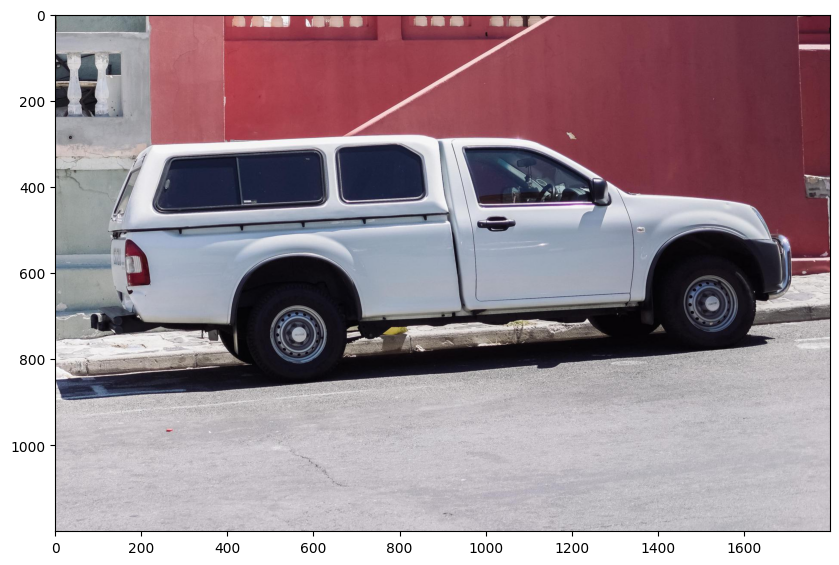

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 2

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
sam2_checkpoint = "/home/cike/workspace/data/model_zoo/SAM2/sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [7]:
for n, p in predictor.model.named_parameters():
    print(n)

maskmem_tpos_enc
no_mem_embed
no_mem_pos_enc
no_obj_ptr
image_encoder.trunk.pos_embed
image_encoder.trunk.pos_embed_window
image_encoder.trunk.patch_embed.proj.weight
image_encoder.trunk.patch_embed.proj.bias
image_encoder.trunk.blocks.0.norm1.weight
image_encoder.trunk.blocks.0.norm1.bias
image_encoder.trunk.blocks.0.attn.qkv.weight
image_encoder.trunk.blocks.0.attn.qkv.bias
image_encoder.trunk.blocks.0.attn.proj.weight
image_encoder.trunk.blocks.0.attn.proj.bias
image_encoder.trunk.blocks.0.norm2.weight
image_encoder.trunk.blocks.0.norm2.bias
image_encoder.trunk.blocks.0.mlp.layers.0.weight
image_encoder.trunk.blocks.0.mlp.layers.0.bias
image_encoder.trunk.blocks.0.mlp.layers.1.weight
image_encoder.trunk.blocks.0.mlp.layers.1.bias
image_encoder.trunk.blocks.1.norm1.weight
image_encoder.trunk.blocks.1.norm1.bias
image_encoder.trunk.blocks.1.attn.qkv.weight
image_encoder.trunk.blocks.1.attn.qkv.bias
image_encoder.trunk.blocks.1.attn.proj.weight
image_encoder.trunk.blocks.1.attn.proj.bi

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.

In [8]:
predictor.set_image(image)

/home/cike/anaconda3/envs/py390/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/cike/workspace/github/REC/mvtec_anomaly_refer/mdetr_knowledge-v0/sam2/modeling/position_encoding.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [9]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

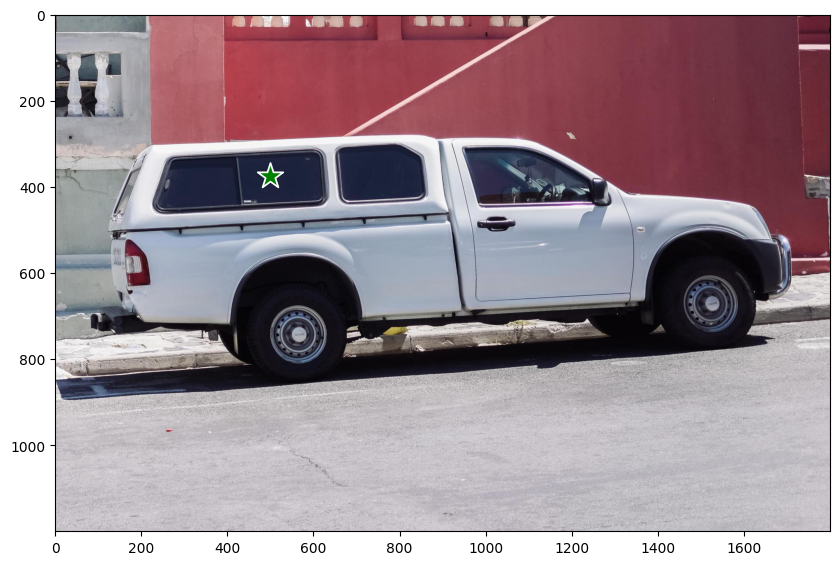

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [11]:
predictor._features["image_embed"].shape, len(predictor._features["high_res_feats"]),#predictor._features["high_res_feats"][0].shape,predictor._features["high_res_feats"][1].shape

(torch.Size([1, 256, 64, 64]), 2)

In [12]:
masks, scores, logits = predictor.predict(
    multimask_output=False,
)
masks.shape, scores.shape, logits.shape

/home/cike/anaconda3/envs/py390/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


((1, 1200, 1800), (1,), (1, 256, 256))

Predict with `SAM2ImagePredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [14]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

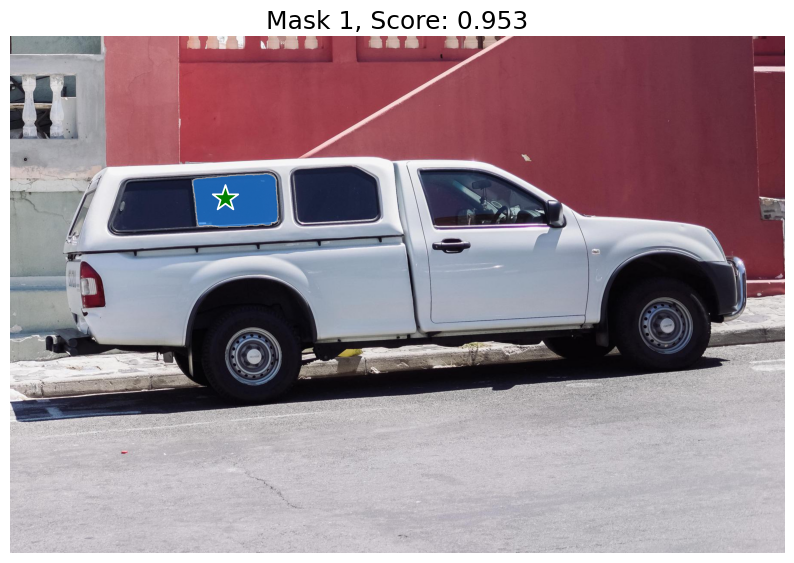

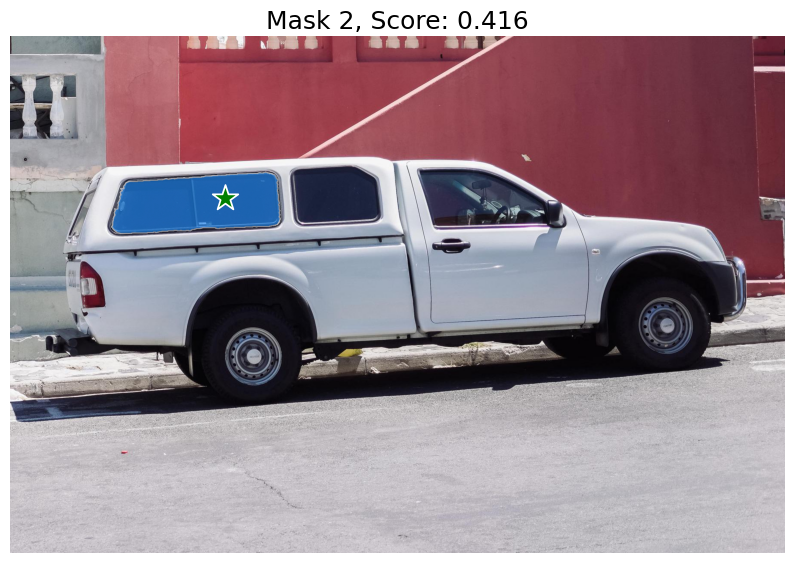

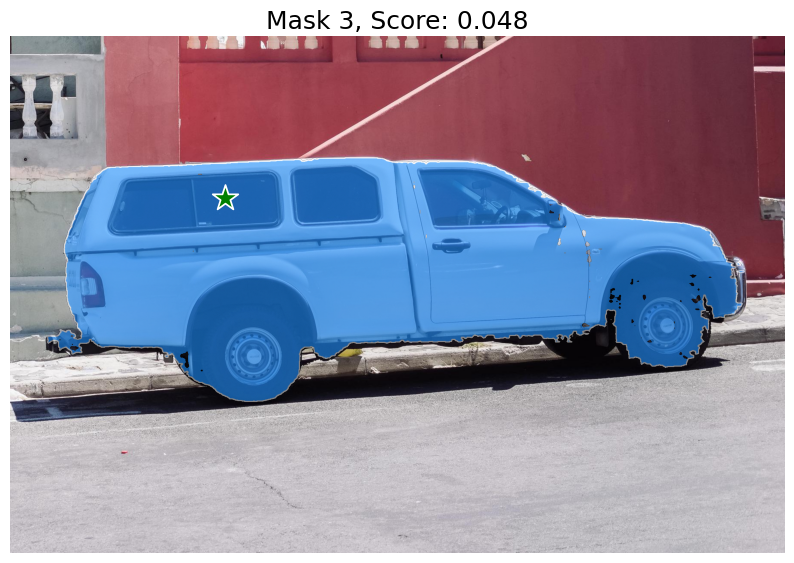

In [15]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [16]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [17]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [18]:
masks.shape

(1, 1200, 1800)

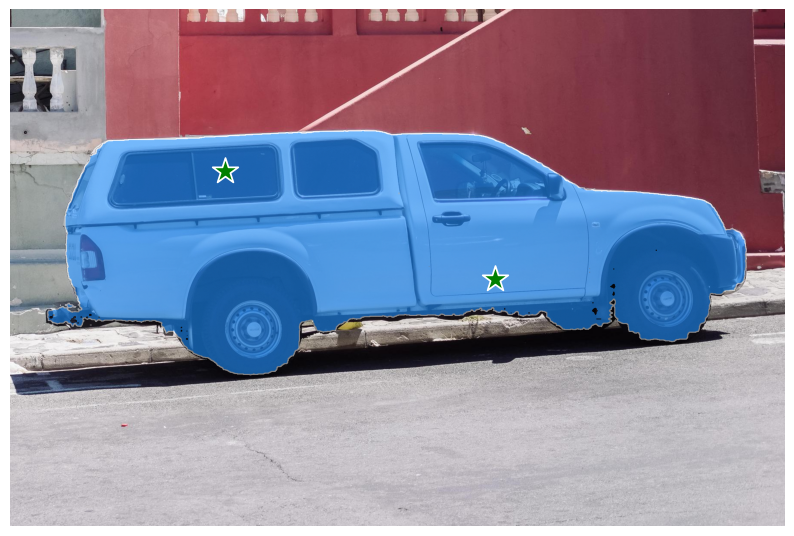

In [19]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [20]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [21]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

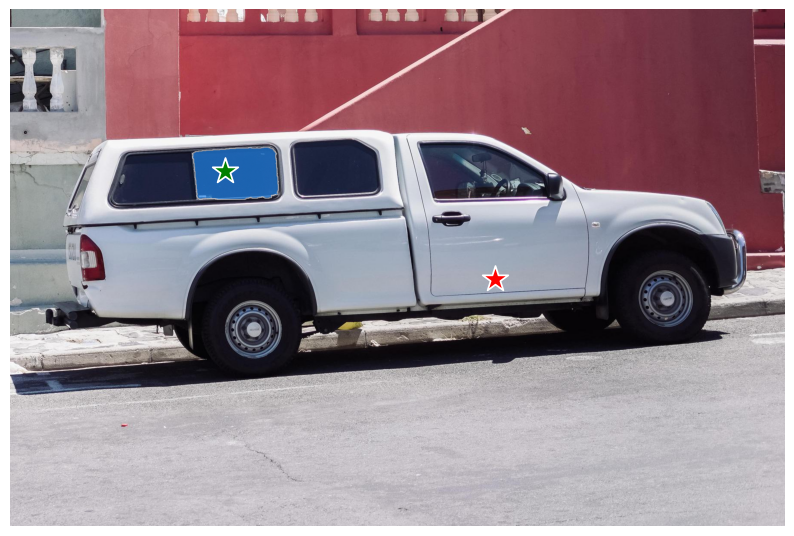

In [22]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [23]:
input_box = np.array([425, 600, 700, 875])

In [24]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

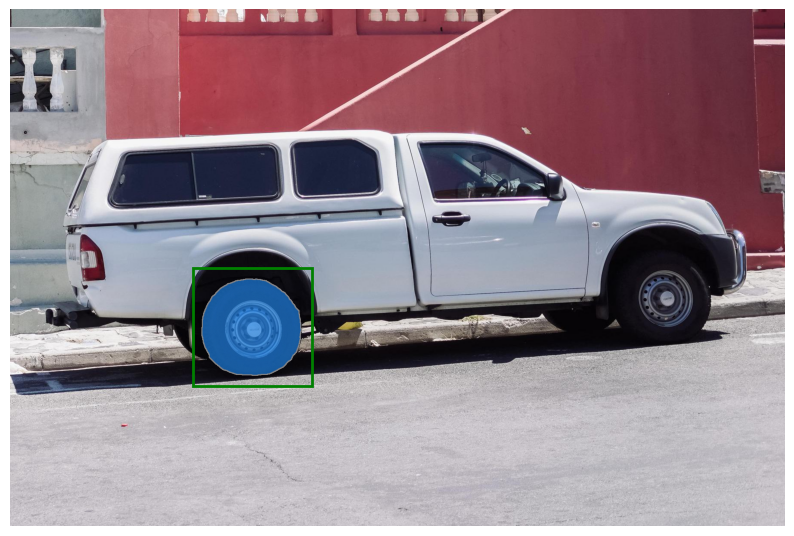

In [25]:
show_masks(image, masks, scores, box_coords=input_box)

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [26]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [27]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

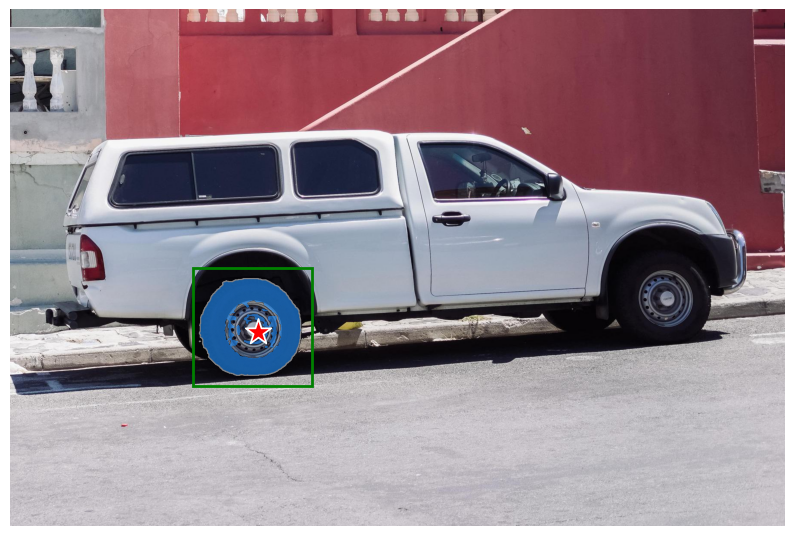

In [28]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

## Batched prompt inputs

`SAM2ImagePredictor` can take multiple input prompts for the same image, using `predict` method. For example, imagine we have several box outputs from an object detector.

In [29]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [30]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [31]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

(4, 1, 1200, 1800)

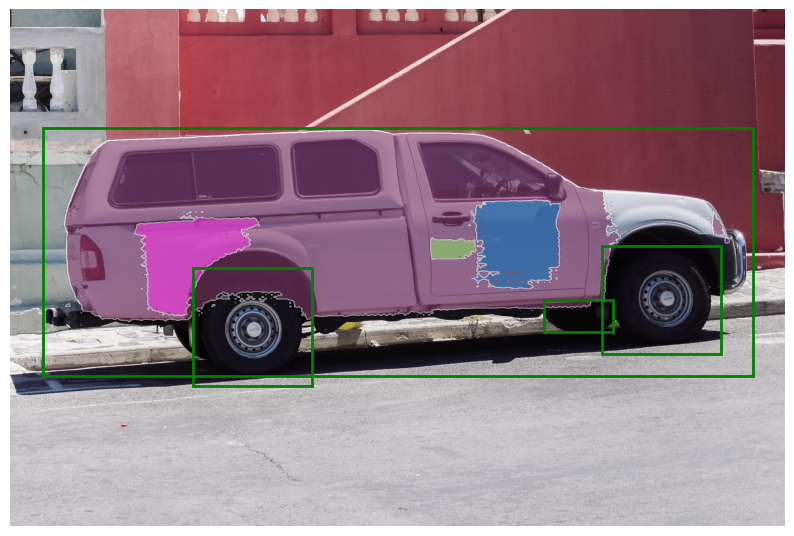

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference
If all prompts are available in advance, it is possible to run SAM 2 directly in an end-to-end fashion. This also allows batching over images.

In [16]:
image1 = image  # truck.jpg from above
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = Image.open('/home/cike/workspace/github/fromgithub/segment-anything-2/notebooks/images/groceries.jpg')
image2 = np.array(image2.convert("RGB"))
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
class SAM2Transforms:
    def __init__(
        self, resolution=1024, max_hole_area=0.0, max_sprinkle_area=0.0
    ):
        """
        Transforms for SAM2.
        """
        super().__init__()
        self.resolution = resolution
        self.max_hole_area = max_hole_area
        self.max_sprinkle_area = max_sprinkle_area
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.to_tensor = ToTensor()
        self.transforms = Compose(
            [
                Resize((self.resolution, self.resolution)),
                Normalize(self.mean, self.std)]
            )
        

    def __call__(self, x):
        x = self.to_tensor(x)
        return self.transforms(x)

    def forward_batch(self, img_list):
        img_batch = [self.transforms(self.to_tensor(img)) for img in img_list]
        img_batch = torch.stack(img_batch, dim=0)
        return img_batch

transforms = SAM2Transforms()
img_batch = [image1, image2]
ori_hw = [image1.shape[:2], image2.shape[:2]]
img_batches = transforms.forward_batch(img_batch)
boxes_batch = [image1_boxes, image2_boxes]

In [21]:
type(image1),image1.shape

(numpy.ndarray, (1200, 1800, 3))

In [17]:
predictor.set_image_batch(img_batches,ori_hw)

/home/cike/anaconda3/envs/py390/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [18]:
masks_batch, scores_batch, _, _ = predictor.predict_batch(
    None,
    None, 
    box_batch=boxes_batch, 
    multimask_output=False
)

/home/cike/anaconda3/envs/py390/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


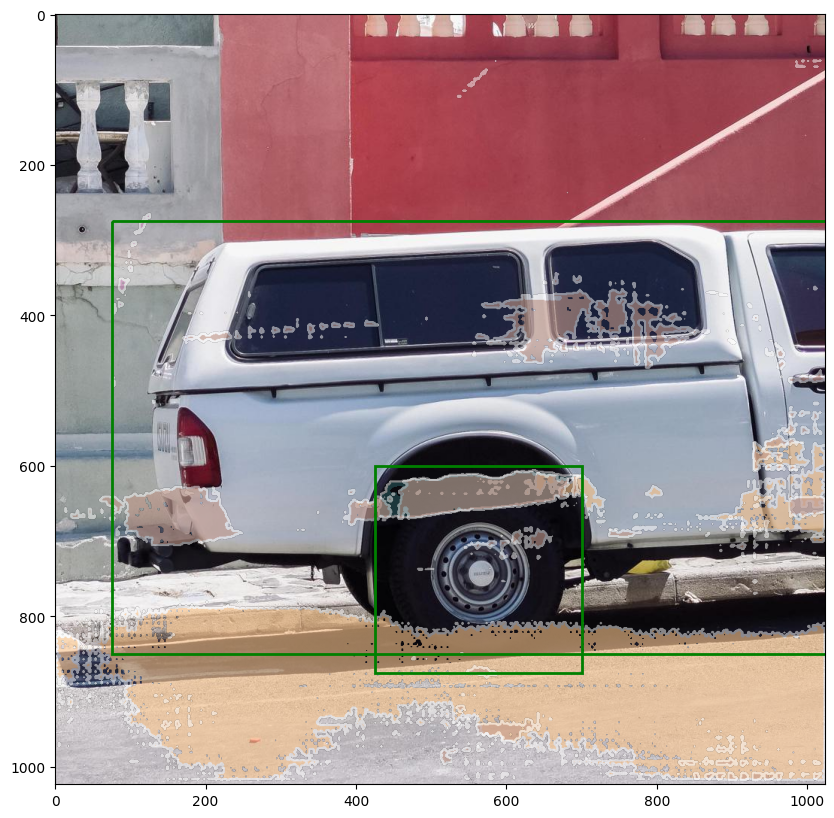

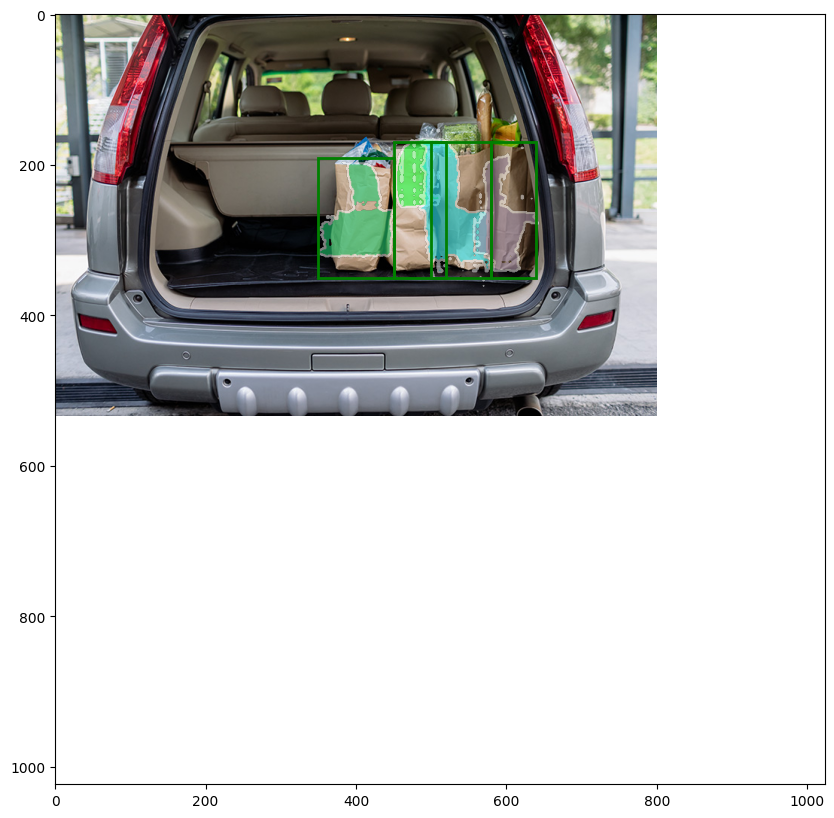

In [19]:
for image, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)   
    for mask in masks:
        mask = mask.cpu().numpy()
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())

Similarly, we can have a batch of point prompts defined over a batch of images

In [34]:
image1 = image  # truck.jpg from above
image1_pts = np.array([
    [[500, 375]],
    [[650, 750]]
    ]) # Bx1x2 where B corresponds to number of objects 
image1_labels = np.array([[1], [1]])

image2_pts = np.array([
    [[400, 300]],
    [[630, 300]],
])
image2_labels = np.array([[1], [1]])

pts_batch = [image1_pts, image2_pts]
labels_batch = [image1_labels, image2_labels]

In [35]:
masks_batch, scores_batch, _, _ = predictor.predict_batch(pts_batch, labels_batch, box_batch=None, multimask_output=True)

# Select the best single mask per object
best_masks = []
for masks, scores in zip(masks_batch,scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores.cpu().numpy(), axis=-1)])

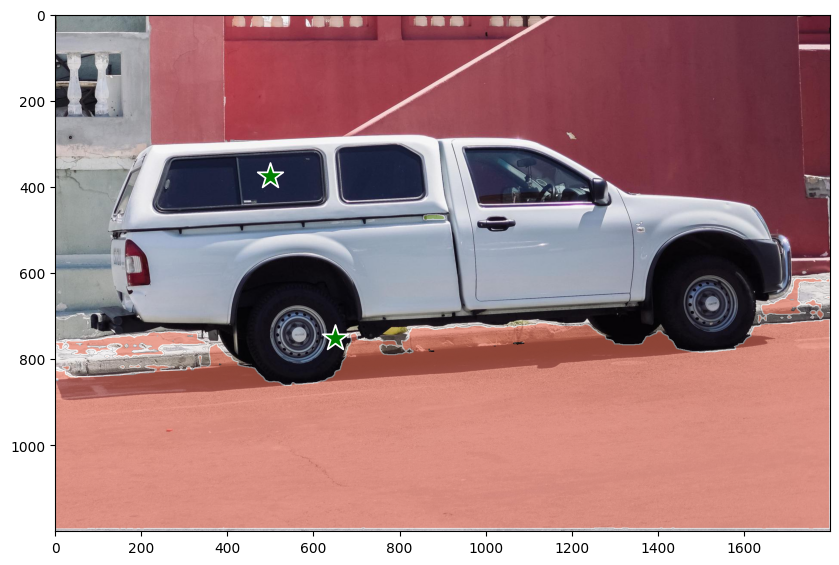

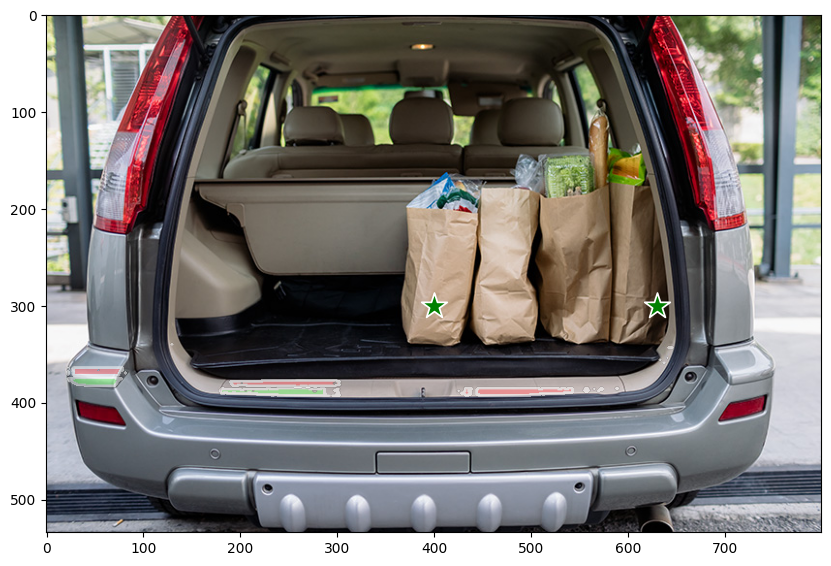

In [36]:
for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)   
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    show_points(points, labels, plt.gca())